# Importations

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW
import torch.optim as optim
from torchsummary import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import plotly.express as px
import seaborn as sns

import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Save model functionality 
save = False

# Helper Functions

In [4]:
def remove_over(df, leng = 512, target='reviews', labels='label'):
    '''Checks text length for being over 512 tokens, 
    which bert-base does not support.'''
    seq_list = []
    seq_len = [len(i.split()) for i in df[target]]
    ugh = []
    for x, y in enumerate(seq_len):
        if y > leng:
            ugh.append(x)
            
    df_tuple = zip(df[target], df[labels])
    
    for x, text in enumerate(df_tuple):
        if x not in ugh:
            seq_list.append(text)
            
    seq_df = pd.DataFrame(seq_list, columns=['reviews','label'])
    
    return seq_df

# Data prep

Pulling in our generated fake reviews and our saved real reviews. 

Fake reviews are generated by a **GPT2** text generator tuned with **50,000** Amazon book reviews.

In [5]:
fake_rev = pd.read_csv('Data/reviewseries.csv')
real_rev = pd.read_csv('Data/realreviews.csv')
fake_rev.rename({'reviewText':'reviews'})

,Unnamed: 0,reviews,label
0,41830,So enjoyable!!! If you are a fan of the serie...,1
1,23419,This book brings together a lot of history an...,1
2,31825,Good work but I would have liked to see more ...,1
3,27356,(Im writing this review in the order it is re...,1
4,9883,"excelente libro de hyenuk, en uno poco, cono ...",1
...,...,...,...
49995,10505,"Russells Introduction is a page-turner, and i...",1
49996,12747,Quick and easy ordering and shipping. It arr...,1
49997,48702,Im used to hearing about a series by John Gri...,1
49998,7944,fun book. What a great ending for the series....,1


In [6]:
fake_rev.drop('Unnamed: 0', inplace=True, axis=1) # Drop unneeded index

In [7]:
fake_rev # Sanity check

,reviews,label
0,So enjoyable!!! If you are a fan of the serie...,1
1,This book brings together a lot of history an...,1
2,Good work but I would have liked to see more ...,1
3,(Im writing this review in the order it is re...,1
4,"excelente libro de hyenuk, en uno poco, cono ...",1
...,...,...
49995,"Russells Introduction is a page-turner, and i...",1
49996,Quick and easy ordering and shipping. It arr...,1
49997,Im used to hearing about a series by John Gri...,1
49998,fun book. What a great ending for the series....,1


In [8]:
real_rev.drop('Unnamed: 0', inplace=True, axis=1) # Drop unneeded index
real_rev['reviews'] = real_rev['reviewText'] # Rename work-around
real_rev.drop('reviewText', inplace=True, axis=1)

In [9]:
real_rev['label'] = 0 # Broadcast label for real-reviews
display(real_rev)

,reviews,label
0,Great book.... Keeps you coming back for more....,0
1,Thanks!,0
2,Required text book for college English class. ...,0
3,The good thing about this book is i have got h...,0
4,First off Heather Dahlgren this is an amazing ...,0
...,...,...
48703,Very interesting book. With a million new book...,0
48704,"This was an excellent, grounded piece of liter...",0
48705,"For this reader, Feverborn, the eighth of ten ...",0
48706,I have been enjoying each one of the Ruth Gall...,0


In [10]:
review_df = pd.concat([real_rev, fake_rev], axis=0) # Join our two dataframes
review_df # sanity check concatenation 

,reviews,label
0,Great book.... Keeps you coming back for more....,0
1,Thanks!,0
2,Required text book for college English class. ...,0
3,The good thing about this book is i have got h...,0
4,First off Heather Dahlgren this is an amazing ...,0
...,...,...
49995,"Russells Introduction is a page-turner, and i...",1
49996,Quick and easy ordering and shipping. It arr...,1
49997,Im used to hearing about a series by John Gri...,1
49998,fun book. What a great ending for the series....,1


In [11]:
review_df.sample(frac=1) # Shuffle dataframe

,reviews,label
2828,Another great map by David E. Hargrave,1
2596,"Upon receiving this product, I have been sear...",1
11269,"Just like in ""Normandy"" by Antony Beevor, ""Sta...",0
3449,This is a GREAT book. I was excited to learn ...,0
16678,Cornwell is back on track with this one...have...,0
...,...,...
16,Bought for Caregiver as a gift. I have now us...,1
18448,Such an amazing book this is. E.L. Todd is one...,0
18418,"Bad boy comes home, investigates a cold case, ...",0
28674,"I'm now into book 4 of this series, and these ...",0


In [12]:
indexrange = list(range(len(review_df))) # Genereated list of integers for new index

In [13]:
review_df['newdex'] = indexrange # Assign index as new columns

In [14]:
review_df.set_index('newdex', inplace=True) # Swap to new index to avoid double assigned indices

In [15]:
review_df = review_df.sample(frac=1) # Shuffle on new index

In [16]:
review_df # Sanity check

,reviews,label
newdex,,
40972,This item was sent as a gift...I was thanked p...,0
26944,"Jame's Ellroy's ""LA Confidential"" is a remarka...",0
8485,Reviewed by Suzanne and posted at Under The Co...,0
50648,At first I didnt want to read it because I lo...,1
98387,Read this book in one sitting. It was amazin...,1
...,...,...
70915,A very well-written novel. It is very short ...,1
24182,Candace Robb has read and researched medieval ...,0
21632,"Good Story, Entertaining and worth the $$$$. S...",0


In [17]:
test = remove_over(review_df) # Using our helper function to cut review length

In [18]:
test # Sanity check

,reviews,label
0,This item was sent as a gift...I was thanked p...,0
1,"Jame's Ellroy's ""LA Confidential"" is a remarka...",0
2,At first I didnt want to read it because I lo...,1
3,Read this book in one sitting. It was amazin...,1
4,I work as a software writer and have the abil...,1
...,...,...
97366,A very well-written novel. It is very short ...,1
97367,Candace Robb has read and researched medieval ...,0
97368,"Good Story, Entertaining and worth the $$$$. S...",0
97369,I was expecting a more serious read of the fi...,1


In [19]:
if save:
    test.to_csv('Data/total_review_df.csv')

# Model Prep

## Train-test split

In [20]:
# Train test split
train_text, temp_text, train_labels, temp_labels = train_test_split(test['reviews'], test['label'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=test['label'])

In [21]:
# Train test split our temp text/labels for a validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## Model and tokenizer assignment

### Bookmark (BERT text here)

In [22]:

bert = AutoModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## Length Analysis

Average length of review: 73.254
Average length of review: 72.858
Average length of review: 73.277


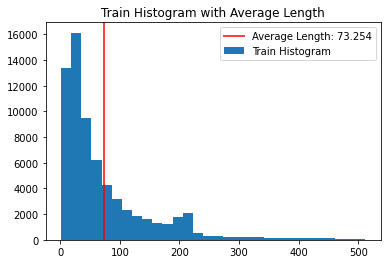

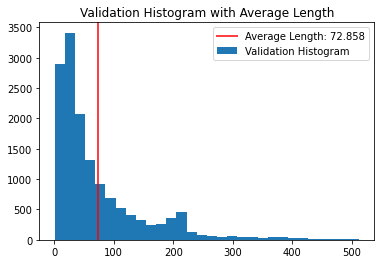

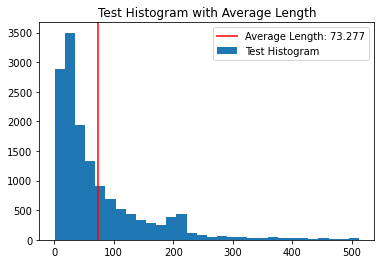

In [23]:
# Split sequences into 'tokens'
train_seq_len = [len(i.split()) for i in train_text]
val_seq_len = [len(i.split()) for i in val_text]
test_seq_len = [len(i.split()) for i in test_text]

# Average length of sequences
train_av = round(np.average(train_seq_len),3)
val_av = round(np.average(val_seq_len),3)
test_av = round(np.average(test_seq_len),3)
print('Average length of review:', train_av)
print('Average length of review:', val_av)
print('Average length of review:', test_av)

# Train historgram
fig, ax = plt.subplots()
plt.title('Train Histogram with Average Length')
plt.hist(pd.Series(train_seq_len), bins=30)
ax.axvline(train_av, color ='red', lw = 2, alpha = 0.75) 
plt.legend(['Average Length: {}'.format(train_av), 'Train Histogram'])
plt.show()

# Validation historgram
fig, ax = plt.subplots()
plt.title('Validation Histogram with Average Length')
plt.hist(pd.Series(val_seq_len), bins=30)
ax.axvline(train_av, color ='red', lw = 2, alpha = 0.75) 
plt.legend(['Average Length: {}'.format(val_av), 'Validation Histogram'])
plt.show()

# Testing historgram
fig, ax = plt.subplots()
plt.title('Test Histogram with Average Length')
plt.hist(pd.Series(test_seq_len), bins=30)
ax.axvline(train_av, color ='red', lw = 2, alpha = 0.75) 
plt.legend(['Average Length: {}'.format(test_av), 'Test Histogram'])
plt.show()

## Tokenization

### Bookmark (Tokenizer text here)

In [24]:
# Using BERT Fast Tokenizer to encode text into input ids

# Training tokens
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 80,
    padding=True,
    truncation=True
)

# Validation Tokens
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 80,
    padding=True,
    truncation=True
)

# Testing tokens
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 80,
    padding=True,
    truncation=True
)

In [25]:
# Store sequences, attention masks, and lables as torch tensors

# Train tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Validation tensors
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Testing tensors
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Dataloaders

## Bookmark (PyTorch dataloader text here)

In [26]:
batch = 128 # Batch size for datalaoder and subsequent model


# Training dataloader
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch)

# Validation dataloader
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_loader = DataLoader(val_data, sampler = val_sampler, batch_size=batch)

# Testing dataloader
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler = test_sampler, batch_size=batch)

# Model

## Bookmark (Model description here)

In [27]:
# Freeze BERT Parameters
for param in bert.parameters():
    param.requires_grad = False

In [28]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        '''
        Professional docstring here
        '''
        
        super(BERT_Arch, self).__init__()
        self.bert = bert
        
        self.droput = nn.Dropout(0.1)
        
        self.relu = nn.ReLU()
        
        self.lstm = nn.LSTM(768,512, bidirectional=True, num_layers=2, dropout=.1)
        self.bn = nn.BatchNorm1d(1024)
        self.fc1 = nn.Linear(1024,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128,2)
        
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, sent_id):
        '''
        Forward pass for model
        '''
        _, x = self.bert(sent_id)
        
        x = x.unsqueeze(0)
        x, _ = self.lstm(x)
        x = x.squeeze(0)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.fc4(x)
        
        x = self.softmax(x)
        
        return x

## Hyperparameters

## Bookmark (AdamW text here)

In [29]:
# Model instantiation 
model = BERT_Arch(bert)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select device programatically
model = model.to(device) # Send model to device (GPU locally)

# AdamW optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5) 

# Computation of class weights for training
class_weights = compute_class_weight('balanced', [0,1], train_labels)
print("Class Weights:",class_weights)
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# Negative log-likelihood loss with weights passed
cross_entropy = nn.NLLLoss(weight=weights)

Class Weights: [1.02776019 0.9737    ]


### Training Epochs

In [30]:
epochs = 50

In [31]:
# function to train the model
def train():
    """
    Future docstring
    """
    model.train()

    total_loss = 0
    total_accuracy = 0

    total_preds=[]
    total_acc=[]
    t0 = time.time()
    # iterate over batches
    for step, batch in enumerate(train_loader):
    
        if step % 100 == 0 and not step == 0:
          lapsed = time.time() - t0
          print('  Batch {:>5,}  of  {:>5,}.  Batch took {} secs'.format(step,
                                                                            len(train_loader),
                                                                            round(lapsed, 3)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        # Pulling apart batch
        sent_id, mask, labels = batch
        
        # Start model
        model.zero_grad()      
        preds = model(sent_id) #Get predictions
        loss = cross_entropy(preds, labels) # Passing through NNL for loss
        total_loss = total_loss + loss.item() # Collect total loss

        loss.backward() # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clipping to avoid exploding grads
        optimizer.step() #Step AdamW
        
        preds_max = F.softmax(preds, dim=1) # Softmax to sum k-real vector to 1
        preds_max = torch.argmax(preds_max, dim=1) # Argmax pulls index of highest value
        wrong = torch.where(preds_max!=labels, # where to generate correct/incorrect tensor
                           torch.tensor([1.]).to(device),
                           torch.tensor([0.]).to(device))
        tot_wrong = int(torch.sum(wrong).detach().cpu()) # sum total incorrect for acc calc
        acc = 1 - tot_wrong/len(labels) # Normalized accuracy calculation
        total_acc.append(acc) # Appends accuracy 

        preds=preds.detach().cpu().numpy() # Send predictions to CPU
        total_preds.append(preds)
    
    # Epoch training loss
    avg_loss = total_loss / len(train_loader)
    total = time.time() - t0
    print('\nTime in seconds: {}'.format(round(total,3)))
    print('Average accuracy: {}'.format((np.average(total_acc))))
    

    
    total_preds  = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds, total_acc

In [32]:
# function for evaluating the model
def evaluate():
    
    """
    Future docstring
    """
    
    print("\nEvaluating...")
    t0 = time.time()
    # Evaluation mode
    model.eval()

    total_loss = 0
    total_accuracy = 0

    # Save predictions
    total_preds = []

    # iterate through loader
    for step,batch in enumerate(val_loader):
        if step % 100 == 0 and not step == 0:
            lapsed = time.time() - t0
            print('  Batch {:>5,}  of  {:>5,}. \n  Eval took {} secs'.format(step,
                                                                            len(val_loader),
                                                                            round(lapsed, 3)))
            
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            # model predictions
            preds = model(sent_id)
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_loader) 
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

## Training loop

### Bookmark (Model training text here) 

In [ ]:
train_losses=[]
valid_losses=[]
total_acc = []
epoch_acc = []

best_valid_loss = float('inf')

for epoch in range(epochs):
    print('---------------------------------------------')
    print('Epoch {:} / {:}'.format(epoch + 1, epochs))
    print('---------------------------------------------')
    
    #train model
    train_loss, _, total_acc = train()

    #evaluate model
    valid_loss, _ = evaluate()
    
    epoch_acc.append(np.average(total_acc))
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Data/BERT_weights.pt')

    # append training and validation loss
    train_losses.append(abs(train_loss))
    valid_losses.append(abs(valid_loss))

    print('\n  Training Loss: {}'.format(abs(round(train_loss, 3))))
    print('  Validation Loss: {}'.format(abs(round(valid_loss, 3))))
print('\n------------------------')   
print('Finished')
print('------------------------')

---------------------------------------------
Epoch 1 / 50
---------------------------------------------
  Batch   100  of    533.  Batch took 35.991 secs
  Batch   200  of    533.  Batch took 74.142 secs
  Batch   300  of    533.  Batch took 112.241 secs
  Batch   400  of    533.  Batch took 152.415 secs
  Batch   500  of    533.  Batch took 189.9 secs

Time in seconds: 202.395
Average accuracy: 0.6585386793084963

Evaluating...
  Batch   100  of    115. 
  Eval took 36.357 secs

  Training Loss: 0.638
  Validation Loss: 0.674
---------------------------------------------
Epoch 2 / 50
---------------------------------------------
  Batch   100  of    533.  Batch took 36.458 secs
  Batch   200  of    533.  Batch took 72.311 secs
  Batch   300  of    533.  Batch took 109.825 secs
  Batch   400  of    533.  Batch took 145.83 secs
  Batch   500  of    533.  Batch took 182.433 secs

Time in seconds: 194.825
Average accuracy: 0.7069711073140952

Evaluating...
  Batch   100  of    115. 
  Ev

In [ ]:
plt.title('Training and Validation loss by Epoch')
plt.plot(train_losses, 'b-o')
plt.plot(valid_losses, 'r-o')
plt.legend(['Train', 'Validation'])
plt.show()

plt.title('Accuracy by Epoch')
plt.plot(epoch_acc, 'b-o')
plt.show()

# Testing

In [ ]:
model.eval()

## Saving


In [ ]:
output_dir = './bert_model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
print("Saving model to {}".format(output_dir))

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
path = 'Data/BERT_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
def testing():
    print("\nTesting...")
    t0 = time.time()
    # Evaluation mode
    model.eval()

    # Save predictions
    total_preds = []
    total_labels = []

    # iterate through loader
    for step,batch in enumerate(test_loader):
        if step % 100 == 0 and not step == 0:
            lapsed = time.time() - t0
            print('  Batch {:>5,}  of  {:>5,}. \n  Test took {} secs'.format(step,
                                                                            len(test_loader),
                                                                            round(lapsed, 3)))

        batch = [t.to(device) for t in batch]
        sent_id, _, labels = batch

        with torch.no_grad():
            # model predictions
            preds = model(sent_id)
            pred = F.softmax(preds, dim=1)
            pred = torch.argmax(preds, dim=1)
            total_preds.append(preds)
            total_labels.append(labels)
            
    

    print('-----------------------')
    print('Testing Finished')
    print('-----------------------')
    return total_preds, total_labels

In [ ]:
test_p, labels = testing()

In [ ]:
test_p = torch.cat(test_p)
test_preds = torch.argmax(test_p, dim=1)

In [ ]:
labels = [label.detach().cpu().numpy() for label in labels]
test_preds = [test_pred.detach().cpu().numpy() for test_pred in test_preds]

In [ ]:
label_true = np.concatenate(labels)

In [ ]:
print(classification_report(label_true, test_preds))

In [ ]:
con_mat = confusion_matrix(y_true=label_true, y_pred=test_preds)
norm_con_mat = confusion_matrix(y_true=label_true, y_pred=test_preds, normalize='true')

In [ ]:
sns.heatmap(con_mat, annot=True, fmt='g')
plt.show()
sns.heatmap(norm_con_mat, annot=True)
plt.show()